### Notebook to prepare the full dataset used for training of different models, combining different code throughout this repo


In [83]:
# Importing Libraries

import pandas as pd
import healpy as hp
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [2]:
# Defining important metrics and functions

# Setting NSIDE valuesfrom sklearn.model_selection import train_test_split
NSIDE = 256
NPIX = hp.nside2npix(NSIDE)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2pixarea(NSIDE, degrees=True)))


def raDec2thetaPhi(ra, dec):
    return (0.5 * np.pi - np.deg2rad(dec)), (np.deg2rad(ra))


Approximate resolution at NSIDE 256 is 0.23 deg
Approximate resolution at NSIDE 256 is 0.052 deg


### 1. Get a catalogue of all objects in the Galaxy Survey



In [3]:
df_north = pd.read_csv('../../bricks_data/galaxy_catalogue_north.csv',
                       dtype={'BrickID': 'int32', 'LRG': 'int8', 'ELG': 'int8', 'QSO': 'int8'})

df_north.head()


,BrickID,RA,DEC,LRG,ELG,QSO
0,541202,140.895285,39.405974,0,0,1
1,541202,140.895584,39.576038,0,0,1
2,541202,140.895693,39.403449,0,0,1
3,541202,140.896081,39.479529,0,0,1
4,541202,140.896304,39.621573,0,1,0


In [6]:
df_south = pd.read_csv('../../bricks_data/galaxy_catalogue_south.csv',
                       dtype={'BrickID': 'int32', 'LRG': 'int8', 'ELG': 'int8', 'QSO': 'int8'})

df_south.head()


,BrickID,RA,DEC,LRG,ELG,QSO
0,387694,350.870568,9.868695,1,0,0
1,387694,350.871680,9.637755,0,1,0
2,387694,350.872142,9.694869,0,0,1
3,387694,350.872631,9.724626,0,0,1
4,387694,350.873243,9.683394,0,1,0


In [7]:
print(len(df_north.BrickID.unique()))
print(len(df_south.BrickID.unique()))
print(len(df_north.BrickID.unique()) + len(df_south.BrickID.unique()))

89085
233866
322951


In [8]:
df = pd.concat((df_south, df_north), axis=0)

In [9]:
print(len(df))

113773918


In [10]:
print(df.shape)
duplicates_removed = df.drop_duplicates()

print(duplicates_removed.shape)

(113773918, 6)
(113739601, 6)


In [11]:
df = duplicates_removed

print(len(df.BrickID.unique()))

312455


In [14]:
print(df.isna().sum())

BrickID         0
RA         137084
DEC        137084
LRG             0
ELG             0
QSO             0
dtype: int64


In [15]:
# Removing all Lines with Nan that were added to ensure that all bricks are stored
df_objects = df.dropna(axis=0, inplace=False, how='any')

print(len(df_objects.BrickID.unique()))
print(len(df_objects))

306439
113602517


### 2. Get Galaxy Count per Healpy Pixel


In [16]:
# LRG

df_LRG = df_objects[df_objects["LRG"] == 1]
ra_LRG = df_LRG["RA"].to_numpy(copy=True)
dec_LRG = df_LRG["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_LRG, dec_LRG)

print("Number of LRGs in Sample:", len(ra_LRG))

LRG_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(LRG_pixel_indices, return_counts=True)

print(unique)

mean_LRG = counts.mean()
print("Mean LRGs per Pixel:", mean_LRG)
# Calculating Densities for every block

#density_LRG = (counts / mean_LRG) - 1
id_density = np.stack((unique, counts), axis=1)
#print(id_density)
df_lrg = pd.DataFrame(id_density, columns=['pixel_id', 'lrg'])
df_lrg.pixel_id = df_lrg.pixel_id.astype(int)
df_lrg.head()

Number of LRGs in Sample: 12651544
[  1558   1560   1561 ... 757955 758427 758428]
Mean LRGs per Pixel: 33.604020303382036


,pixel_id,lrg
0,1558,2
1,1560,1
2,1561,3
3,1562,1
4,1564,2


In [17]:
# elg

df_ELG = df_objects[df_objects["ELG"] == 1]
ra_ELG = df_ELG["RA"].to_numpy(copy=True)
dec_ELG = df_ELG["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_ELG, dec_ELG)

print("Number of ELGs in Sample:", len(ra_ELG))

ELG_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(ELG_pixel_indices, return_counts=True)

print(unique)

mean_ELG = counts.mean()
print("Mean ELGs per Pixel:", mean_ELG)
# Calculating Densities for every block
#density_ELG = (counts / mean_ELG) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_elg = pd.DataFrame(id_density, columns=['pixel_id', 'elg'])
df_elg.pixel_id = df_elg.pixel_id.astype(int)

print(df_elg.head())

Number of ELGs in Sample: 47256924
[  1558   1559   1560 ... 758428 758429 758430]
Mean ELGs per Pixel: 124.99318655508416
[[  1558      6]
 [  1559      3]
 [  1560      7]
 ...
 [758428     12]
 [758429      4]
 [758430      6]]
   pixel_id  elg
0      1558    6
1      1559    3
2      1560    7
3      1561    4
4      1562    5


In [18]:
df_QSO = df_objects[df_objects["QSO"] == 1]
ra_QSO = df_QSO["RA"].to_numpy(copy=True)
dec_QSO = df_QSO["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_QSO, dec_QSO)

print("Number of QSOs in Sample:", len(ra_QSO))

QSO_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(QSO_pixel_indices, return_counts=True)

print(unique)

mean_QSO = counts.mean()
print("Mean QSOs per Pixel:", mean_QSO)
# Calculating Densities for every block
#density_QSO = (counts / mean_QSO) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_qso = pd.DataFrame(id_density, columns=['pixel_id', 'qso'])
df_qso.pixel_id = df_qso.pixel_id.astype(int)

print(df_qso.head())

Number of QSOs in Sample: 59117673
[  1558   1559   1560 ... 758428 758429 758430]
Mean QSOs per Pixel: 156.29507143536975
[[  1558      9]
 [  1559      5]
 [  1560      8]
 ...
 [758428      6]
 [758429      6]
 [758430      4]]
   pixel_id  qso
0      1558    9
1      1559    5
2      1560    8
3      1561    6
4      1562    6


In [19]:
df = pd.merge(df_lrg, df_elg, how='outer', on='pixel_id')
df = pd.merge(df, df_qso, how='outer', on='pixel_id')
print(df.isna().sum())
print(df_lrg.shape, df_elg.shape, df_qso.shape, df.shape)

pixel_id       0
lrg         2070
elg          483
qso          315
dtype: int64
(376489, 2) (378076, 2) (378244, 2) (378559, 4)


In [20]:
# Dropping all pixels where I do not have counts for all 3 types of galaxies
df.dropna(axis=0, inplace=True)
print(df.isna().sum())
print(df.shape)

pixel_id    0
lrg         0
elg         0
qso         0
dtype: int64
(376262, 4)


### 3. Plotting Galaxy Densities

In [ ]:
m_LRG = np.zeros(NPIX)

m_LRG[df.pixel_id.to_numpy()] = df.lrg.to_numpy()
mask = (m_LRG == 0)
m_LRG[mask] = np.nan
hp.mollview(m_LRG, title="LRG", format='%i', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

In [ ]:
m_ELG = np.zeros(NPIX)

m_ELG[df.pixel_id.to_numpy()] = df.elg.to_numpy()
mask = (m_ELG == 0)
m_ELG[mask] = np.nan
hp.mollview(m_ELG, title="ELG", format='%i', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

In [ ]:
m_QSO = np.zeros(NPIX)

m_QSO[df.pixel_id.to_numpy()] = df.qso.to_numpy()
mask = (m_QSO == 0)
m_QSO[mask] = np.nan
hp.mollview(m_QSO, title="QSO", format='%i', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

In [21]:
# Getting Exposure Densities across pixels

with open('../../bricks_data/pixel2ccd_256.pickle', 'rb') as f:
    pixel2ccd_dict = pickle.load(f)
    f.close()

In [22]:
df = df.astype(int)
df.head()



,pixel_id,lrg,elg,qso
0,1558,2,6,9
1,1560,1,7,8
2,1561,3,4,6
3,1562,1,5,6
4,1564,2,4,10


In [23]:
pix_ids = df.pixel_id.to_numpy()
exp_len = np.zeros(len(pix_ids))
print(pix_ids)
for i, pix in enumerate(pix_ids):
    exp_len[i] = len(pixel2ccd_dict[pix])

print(exp_len)

df['exposures'] = exp_len

df.head()

[  1558   1560   1561 ... 757955 758427 758428]
[10. 11. 10. ...  8.  6.  9.]


,pixel_id,lrg,elg,qso,exposures
0,1558,2,6,9,10.0
1,1560,1,7,8,11.0
2,1561,3,4,6,10.0
3,1562,1,5,6,10.0
4,1564,2,4,10,10.0


In [24]:
df = df.astype(int)


In [ ]:
m_EXP = np.zeros(NPIX)

m_EXP[df.pixel_id.to_numpy()] = df.exposures.to_numpy()
mask = (m_EXP == 0)
m_EXP[mask] = np.nan
hp.mollview(m_EXP, title="EXP", format='%i', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

### 4. Importing the Systematics Values and Appending them to the df.


#### a. Stellar Density

In [25]:
df_stellar_north = pd.read_csv('../../bricks_data/stellar_catalogue_north.csv')


In [26]:
df_stellar_south = pd.read_csv('../../bricks_data/stellar_catalogue_south.csv')

In [72]:
df_stellar_north.head()

,RA,DEC,GMAG,RMAG,ZMAG
0,140.898014,39.467598,18.104998,17.247044,16.888790
1,140.931050,39.523490,18.810522,17.796021,17.333416
2,140.957915,39.428128,19.376871,17.902054,16.362108
3,140.972733,39.467930,19.390877,17.886087,16.718546
4,140.981984,39.563177,18.225065,17.742722,17.618404


In [74]:
print(len(df_stellar_north) + len(df_stellar_south))

12678642


In [27]:
df_stellar = pd.concat((df_stellar_south, df_stellar_north), axis=0)


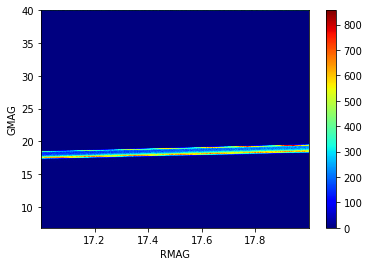

In [28]:
label_1 = 'RMAG'
label_2 = 'GMAG'

plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [29]:
# REMOVING OUTLIERS
print(df_stellar.shape)

(12928723, 5)


In [30]:
df_stellar['GMR'] = df_stellar['GMAG'] - df_stellar['RMAG']
df_stellar['RMZ'] = df_stellar['RMAG'] - df_stellar['ZMAG']

In [31]:
df_stellar = df_stellar[(df_stellar['GMAG'] > 15) & (df_stellar['GMAG'] < 30)]
df_stellar = df_stellar[(df_stellar['ZMAG'] > 15) & (df_stellar['ZMAG'] < 30)]
df_stellar = df_stellar[(df_stellar['GMR'] > -2) & (df_stellar['GMR'] < 4)]
df_stellar = df_stellar[(df_stellar['RMZ'] > -2) & (df_stellar['RMZ'] < 4)]
print(df_stellar.shape)


(12315406, 7)


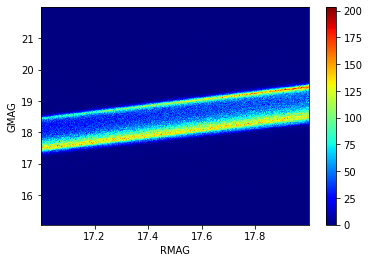

In [32]:
plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()


In [33]:
#Dividing RMAG Column into 1000 equally filled bins (assuming within the RMAG of 17-18 this is somewhat uniform)
df_stellar['percent_RMAG'] = pd.qcut(df_stellar['RMAG'], q=1000, labels=False)
df_stellar['percent_RMAG'].value_counts()


818    12357
867    12356
912    12355
620    12351
585    12348
       ...  
823    12283
843    12281
913    12279
931    12277
621    12275
Name: percent_RMAG, Length: 1000, dtype: int64

In [34]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_RMAG')
zscore = lambda x: abs((x - x.median()) / x.std())
df_stellar['Z_SCORE_RMZ'] = grouped['RMZ'].transform(zscore)
df_stellar['Z_SCORE_GMR'] = grouped['GMR'].transform(zscore)

In [35]:
#Dividing RMAG Column into 100 equally filled bins (assuming within the RMAG of 17-18 this is somewhat uniform)
df_stellar['percent_GMR'] = pd.qcut(df_stellar['GMR'], q=1000, labels=False)
df_stellar['percent_RMZ'] = pd.qcut(df_stellar['RMZ'], q=1000, labels=False)
df_stellar.shape

(12315406, 12)

In [36]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_GMR')
df_stellar['Z_SCORE_RMZ'] = grouped['RMZ'].transform(zscore)


In [37]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_RMZ')
df_stellar['Z_SCORE_GMR'] = grouped['GMR'].transform(zscore)

In [38]:
print(df_stellar.shape)
df_stellar = df_stellar[(df_stellar['Z_SCORE_GMR'] < 3)]
print(df_stellar.shape)
df_stellar = df_stellar[(df_stellar['Z_SCORE_RMZ'] < 3)]
df_stellar.shape

(12315406, 12)
(12224980, 12)


(12169883, 12)

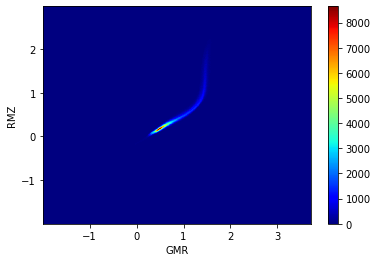

In [39]:
label_1 = 'GMR'
label_2 = 'RMZ'

plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [40]:
ra_stellar = df_stellar["RA"].to_numpy(copy=True)
dec_stellar = df_stellar["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_stellar, dec_stellar)

print("Number of stellars in Sample:", len(ra_stellar))

stellar_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(stellar_pixel_indices, return_counts=True)

print(unique)

mean_stellar = counts.mean()
print("Mean stellars per Pixel:", mean_stellar)
# Calculating Densities for every block
density_stellar = (counts / mean_stellar) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_stellar = pd.DataFrame(id_density, columns=['pixel_id', 'stellar'])
df_stellar.pixel_id = df_stellar.pixel_id.astype(int)

print(df_stellar.head())

print(df_stellar.isna().sum())

Number of stellars in Sample: 12169883
[  1560   1561   1562 ... 757955 758426 758427]
Mean stellars per Pixel: 32.32836316496921
[[  1560      1]
 [  1561      3]
 [  1562      2]
 ...
 [757955      4]
 [758426      2]
 [758427      2]]
   pixel_id  stellar
0      1560        1
1      1561        3
2      1562        2
3      1565        3
4      1572        1
pixel_id    0
stellar     0
dtype: int64


In [41]:
df = df.merge(df_stellar, how='inner', on='pixel_id')
print(df.isna().sum())
df.shape

pixel_id     0
lrg          0
elg          0
qso          0
exposures    0
stellar      0
dtype: int64


(375274, 6)

In [42]:
df.head()

,pixel_id,lrg,elg,qso,exposures,stellar
0,1560,1,7,8,11,1
1,1561,3,4,6,10,3
2,1562,1,5,6,10,2
3,1565,2,11,7,9,3
4,1572,1,3,10,6,1


0.0 180.0 -180.0 180.0


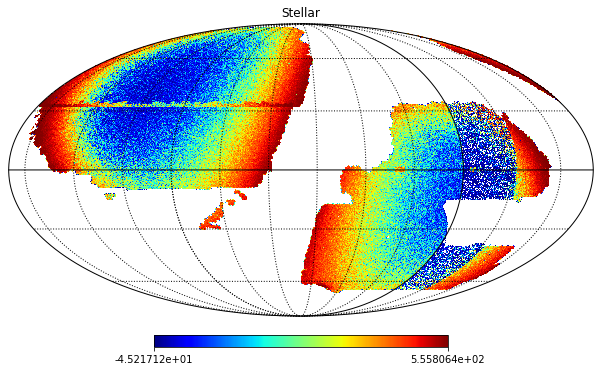

In [94]:
m_Stellar = np.zeros(NPIX)

m_Stellar[df.pixel_id.to_numpy()] = df.stellar.to_numpy()
mask = (m_Stellar == 0)
m_Stellar[mask] = np.nan
hp.mollview(m_Stellar, title="Stellar", format='%e', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0),
            badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

#### EBV Extraction

In [43]:
from astropy.coordinates import SkyCoord, Latitude, Longitude
from dustmaps.sfd import SFDQuery

In [44]:
from dustmaps.config import config

config['data_dir'] = '/Users/edgareggert/astrostatistics/data_preprocessing/.dustmapsrc'

In [45]:
## Getting the centers of each pixel in my corpus as RaDec

pixels_ids = df["pixel_id"].to_numpy()
print(pixels_ids)
subpixel_coords = hp.pix2ang(NSIDE, pixels_ids, lonlat=True)
ra_ebv = subpixel_coords[0]
dec_ebv = subpixel_coords[1]

[  1560   1561   1562 ... 757954 757955 758427]


In [46]:
#Querying their position on the SFD dustmap
sfd = SFDQuery()
coords = SkyCoord(ra_ebv, dec_ebv, frame='icrs', unit='deg')
ebv = sfd(coords)

df["EBV"] = ebv

In [47]:
df.EBV.describe()
df.head()


,pixel_id,lrg,elg,qso,exposures,stellar,EBV
0,1560,1,7,8,11,1,0.157148
1,1561,3,4,6,10,3,0.277929
2,1562,1,5,6,10,2,0.255054
3,1565,2,11,7,9,3,0.247232
4,1572,1,3,10,6,1,0.209759


0.0 180.0 -180.0 180.0


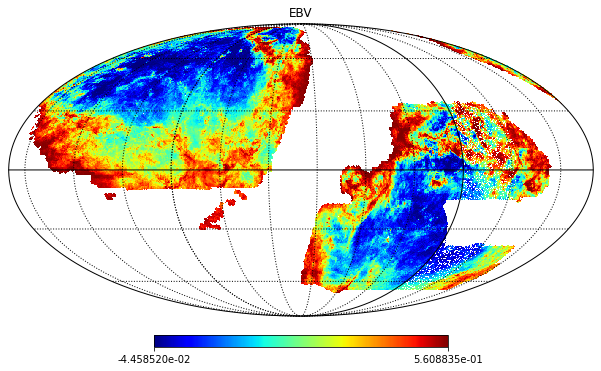

In [102]:
m_EBV = np.zeros(NPIX)

m_EBV[df.pixel_id.to_numpy()] = df.EBV.to_numpy()
mask = (m_EBV == 0)
m_EBV[mask] = np.nan
hp.mollview(m_EBV, title="EBV", format='%e', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

In [104]:
df.exposures = df.exposures.astype(int)
df.head()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV
0,1560,1,7,8,11,1,0.157148
1,1561,3,4,6,10,3,0.277929
2,1562,1,5,6,10,2,0.255054
3,1565,2,11,7,9,3,0.247232
4,1572,1,3,10,6,1,0.209759


In [48]:
df.to_csv('../../bricks_data/dataset_galdense.csv', index=False)



In [2]:
df = pd.read_csv('../../bricks_data/dataset_galdense.csv',
                 dtype={'pixel_id': 'int32', 'lrg': 'int32', 'elg': 'int32', 'qso': 'int32', 'exposures': 'int32',
                        'EBV': 'float'})

#### Geometric Systematics Values, not involving edge pixels

In [49]:
with open('../../bricks_data/pixel2systematics_geometric_non_inclusive.pickle', 'rb') as f:
    geo_dict = pickle.load(f)
    f.close()

print(len(geo_dict.keys()))

446042


In [50]:
sys_list = []
for key in geo_dict.keys():
    ind_sys_list = geo_dict[key]
    ind_sys_list.append(key)
    sys_list.append(ind_sys_list)

df_sys_geo_no = pd.DataFrame(sys_list, columns=['airmass',
                                                'ccdskysb_g',
                                                'ccdskysb_r',
                                                'ccdskysb_z',
                                                'exptime_g',
                                                'exptime_r',
                                                'exptime_z',
                                                'meansky_g',
                                                'meansky_r',
                                                'meansky_z',
                                                'galdepth_g',
                                                'galdepth_r',
                                                'galdepth_z',
                                                'seeing_g',
                                                'seeing_r',
                                                'seeing_z',
                                                'mjd_obs_g',
                                                'mjd_obs_r',
                                                'mjd_obs_z', 'pixel_id'])



In [51]:
print(len((df_sys_geo_no)))

446042


In [52]:
df_geo = df.merge(df_sys_geo_no, how='inner', on='pixel_id')
print(len(df))
print(len(df_geo))

375274
373687


In [53]:
print(df_geo.isna().sum())

pixel_id       0
lrg            0
elg            0
qso            0
exposures      0
stellar        0
EBV            0
airmass        0
ccdskysb_g    52
ccdskysb_r    33
ccdskysb_z     4
exptime_g      0
exptime_r      0
exptime_z      0
meansky_g      0
meansky_r      0
meansky_z      0
galdepth_g     0
galdepth_r     0
galdepth_z     0
seeing_g       0
seeing_r       0
seeing_z       0
mjd_obs_g      0
mjd_obs_r      0
mjd_obs_z      0
dtype: int64


In [54]:
df_geo.dropna(axis=0, inplace=True)
print(df_geo.isna().sum())

pixel_id      0
lrg           0
elg           0
qso           0
exposures     0
stellar       0
EBV           0
airmass       0
ccdskysb_g    0
ccdskysb_r    0
ccdskysb_z    0
exptime_g     0
exptime_r     0
exptime_z     0
meansky_g     0
meansky_r     0
meansky_z     0
galdepth_g    0
galdepth_r    0
galdepth_z    0
seeing_g      0
seeing_r      0
seeing_z      0
mjd_obs_g     0
mjd_obs_r     0
mjd_obs_z     0
dtype: int64


In [55]:
print(df_geo.describe())

            pixel_id            lrg            elg            qso  \
count  373605.000000  373605.000000  373605.000000  373605.000000   
mean   335748.377152      33.794542     126.155105     157.883141   
std    204660.767148      14.856976      36.365488      43.447255   
min      1667.000000       1.000000       1.000000       1.000000   
25%    174544.000000      26.000000     111.000000     140.000000   
50%    316569.000000      32.000000     126.000000     158.000000   
75%    461508.000000      40.000000     141.000000     177.000000   
max    757954.000000     708.000000    2936.000000    2040.000000   

           exposures        stellar            EBV        airmass  \
count  373605.000000  373605.000000  373605.000000  373605.000000   
mean       99.835409      32.447641       0.041948       1.354511   
std       248.427538      29.880998       0.032643       0.253724   
min         5.000000       1.000000       0.000583       1.000179   
25%        46.000000      15.0000

In [15]:
df_geo.to_csv('../../bricks_data/dataset_geometric.csv', index=False)


#### Plotting All Densities and systematics together


In [ ]:
cols = list(df_geo.columns)
cols.remove('pixel_id')
cols.remove('Z')

In [159]:
nrows = 25
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,20))

#fig = plt.figure()
i = 0
for ax in ax.flatten():
    elem = cols[i]

    m = np.zeros(NPIX)

    m[df_geo.pixel_id.to_numpy()] = df_geo[elem].to_numpy()
    mask = (m == 0)
    m[mask] = np.nan
    plt.axes(ax)
    hp.mollview(m, title=elem, fig=fig, sub=(nrows, ncols, i + 1),format='%e', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
    hp.graticule()
    i += 1

plt.show()


/Users/edgareggert/miniconda3/envs/astro/lib/python3.8/site-packages/matplotlib/transforms.py:2525: RuntimeWarning: invalid value encountered in double_scalars
  y_scale = outh / inh
posx and posy should be finite values
0.0 180.0 -180.0 180.0
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.

KeyboardInterrupt: 

ValueError: cannot convert float NaN to integer

### 5. Outlier Removal

In [92]:
df_geo = pd.read_csv('../../bricks_data/dataset_geometric.csv',
                     dtype={'pixel_id': 'int32', 'lrg': 'int32', 'elg': 'int32', 'qso': 'int32', 'exposures': 'int32',
                            'EBV': 'float'})

df_geo.describe()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV,airmass,ccdskysb_g,ccdskysb_r,...,meansky_z,galdepth_g,galdepth_r,galdepth_z,seeing_g,seeing_r,seeing_z,mjd_obs_g,mjd_obs_r,mjd_obs_z
count,372013.000000,372013.000000,372013.000000,372013.000000,372013.000000,372013.000000,372013.000000,372013.000000,372013.000000,372013.000000,...,3.720130e+05,372013.000000,372013.000000,372013.000000,372013.000000,372013.000000,372013.000000,372013.000000,372013.000000,372013.000000
mean,335304.439089,33.454178,124.915761,156.338340,99.779242,31.925454,0.041886,1.354411,23.463687,22.586242,...,7.851226e+08,23.670302,23.155528,22.228207,1.226119,1.103748,1.100957,57796.040291,57785.939716,57682.891118
std,204674.135474,15.014601,37.753622,45.263385,248.910733,29.836044,0.032636,0.253647,0.181780,0.226946,...,3.224604e+09,0.299719,0.335746,0.263588,0.491326,0.324000,0.364973,355.313251,350.768907,304.939144
min,1667.000000,1.000000,1.000000,1.000000,5.000000,1.000000,0.000583,1.000179,18.267529,18.225866,...,0.000000e+00,18.361883,15.734725,0.000000,0.573780,0.542340,0.000000,56536.000831,56536.081054,0.000000
25%,173977.000000,25.000000,110.000000,139.000000,46.000000,14.000000,0.019654,1.182383,23.383179,22.475093,...,2.054567e+00,23.504389,22.936856,22.167023,1.089711,0.984344,0.992421,57530.141949,57513.017332,57477.084885
50%,316018.000000,32.000000,126.000000,158.000000,69.000000,21.000000,0.032588,1.272105,23.487003,22.610316,...,2.518627e+00,23.728531,23.226883,22.286766,1.239524,1.121402,1.078152,57799.682085,57778.555403,57653.940185
75%,461331.000000,40.000000,141.000000,177.000000,134.000000,37.000000,0.053174,1.486924,23.572754,22.726754,...,3.323794e+00,23.872334,23.356679,22.378192,1.352809,1.217051,1.179276,58066.476635,58057.969587,57877.869716
max,757954.000000,708.000000,2936.000000,2040.000000,17612.000000,1951.000000,0.854514,2.385126,24.377570,25.279337,...,9.433031e+10,24.705928,24.181324,27.191251,53.560776,32.342494,58.909491,58662.327740,58661.994609,58679.138231


In [93]:
zscore = lambda x: abs((x - x.median()) / x.std())
col = list(df_geo.columns)
df_no_outlier = df_geo


#### Removing All Outliers


In [94]:
df_no_outlier = df_geo

print(len(df_geo))
for elem in col:
    df_no_outlier['Z'] = df_no_outlier[elem].transform(zscore)
    print("Element: ", elem, "| No of Elems with Z > 4: ", len(df_no_outlier[(df_no_outlier['Z'] > 4)]))
    df_no_outlier = df_no_outlier[(df_no_outlier['Z'] < 4)]

print()
print(f"Galaxies Remaining before outlier removal: {len(df_geo)}")
print(f"Galaxies Remaining after outlier removal: {len(df_no_outlier)}")
print(f"Elements cut by outlier removal: {len(df_geo) - len(df_no_outlier)}")

372013
Element:  pixel_id | No of Elems with Z > 4:  0
Element:  lrg | No of Elems with Z > 4:  2214
Element:  elg | No of Elems with Z > 4:  1753
Element:  qso | No of Elems with Z > 4:  805
Element:  exposures | No of Elems with Z > 4:  661
Element:  stellar | No of Elems with Z > 4:  4977
Element:  EBV | No of Elems with Z > 4:  3503
Element:  airmass | No of Elems with Z > 4:  432
Element:  ccdskysb_g | No of Elems with Z > 4:  2270
Element:  ccdskysb_r | No of Elems with Z > 4:  2181
Element:  ccdskysb_z | No of Elems with Z > 4:  22
Element:  exptime_g | No of Elems with Z > 4:  549
Element:  exptime_r | No of Elems with Z > 4:  2780
Element:  exptime_z | No of Elems with Z > 4:  1177
Element:  meansky_g | No of Elems with Z > 4:  7137
Element:  meansky_r | No of Elems with Z > 4:  6389
Element:  meansky_z | No of Elems with Z > 4:  6182
Element:  galdepth_g | No of Elems with Z > 4:  1078
Element:  galdepth_r | No of Elems with Z > 4:  982
Element:  galdepth_z | No of Elems with

In [95]:
df_no_outlier.describe()
df_no_outlier.exposures.max()

df_no_outlier = df_no_outlier[df_no_outlier.exposures < 300]
df_no_outlier.exposures.max()


299

### Scaling the Data

In [96]:
scaler = MinMaxScaler()
#scaler = RobustScaler()

df_scaled = df_no_outlier

df_scaled[df_scaled.columns] = scaler.fit_transform(df_no_outlier[df_no_outlier.columns])

df_scaled.describe()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV,airmass,ccdskysb_g,ccdskysb_r,...,galdepth_g,galdepth_r,galdepth_z,seeing_g,seeing_r,seeing_z,mjd_obs_g,mjd_obs_r,mjd_obs_z,Z
count,323472.000000,323472.000000,323472.000000,323472.000000,323472.000000,323472.000000,323472.000000,323472.000000,323472.000000,323472.000000,...,323472.000000,323472.000000,323472.000000,323472.000000,323472.000000,323472.000000,323472.000000,323472.000000,323472.000000,323472.000000
mean,0.424106,0.349830,0.451634,0.487889,0.274546,0.205281,0.244794,0.281154,0.548983,0.502329,...,0.538999,0.543424,0.505492,0.408463,0.375334,0.293916,0.598181,0.594457,0.532425,0.205569
std,0.253146,0.132254,0.114484,0.120046,0.189624,0.174539,0.169700,0.198135,0.109339,0.111624,...,0.131507,0.136461,0.116033,0.132083,0.127239,0.089716,0.161558,0.159902,0.134531,0.159677
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.225988,0.263736,0.401460,0.436709,0.139456,0.094891,0.120203,0.147903,0.480194,0.433779,...,0.441631,0.441863,0.456662,0.324773,0.294455,0.231504,0.482921,0.471170,0.436966,0.079312
50%,0.405399,0.340659,0.456204,0.493671,0.210884,0.145985,0.197795,0.217368,0.559456,0.510868,...,0.563806,0.568217,0.523927,0.423404,0.390647,0.284426,0.600308,0.592759,0.519453,0.170406
75%,0.580733,0.417582,0.510949,0.553797,0.306122,0.248175,0.318316,0.383178,0.627380,0.578237,...,0.635980,0.626180,0.579801,0.497097,0.456567,0.345642,0.719329,0.716888,0.621965,0.298175
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Separating train, test and validation sets

In [97]:
df_train, df_val = train_test_split(df_scaled, test_size=0.4, random_state=44, shuffle=True)
df_val, df_test = train_test_split(df_val, test_size=0.5, random_state=44, shuffle=True)

total = len(df_train) + len(df_test) + len(df_val)

print(len(df_train)/total)
print(len(df_val)/total)
print(len(df_test)/total)

0.5999993817084631
0.19999876341692635
0.20000185487461047


In [74]:
df_train.describe()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV,airmass,ccdskysb_g,ccdskysb_r,...,galdepth_g,galdepth_r,galdepth_z,seeing_g,seeing_r,seeing_z,mjd_obs_g,mjd_obs_r,mjd_obs_z,Z
count,224163.000000,224163.000000,224163.000000,224163.000000,224163.000000,224163.000000,224163.000000,224163.000000,224163.000000,224163.000000,...,224163.000000,224163.000000,224163.000000,224163.000000,224163.000000,224163.000000,224163.000000,224163.000000,224163.000000,224163.000000
mean,335663.405723,33.800092,126.127033,157.868212,99.307794,32.448147,0.041947,1.354598,23.464100,22.586883,...,23.669821,23.155946,22.228117,1.226217,1.104251,1.101249,57796.232191,57786.525733,57683.343008,0.826617
std,204694.829764,14.998503,36.477706,43.223090,236.739434,30.003102,0.032656,0.254054,0.181305,0.226269,...,0.301412,0.334934,0.261033,0.485555,0.326060,0.362652,355.508148,351.024310,290.374858,0.570735
min,1667.000000,1.000000,1.000000,1.000000,5.000000,1.000000,0.001282,1.000540,18.594616,18.225866,...,18.361883,16.510733,13.926624,0.573780,0.542340,0.614027,56536.000831,56536.081054,56545.587710,0.000000
25%,174269.000000,26.000000,111.000000,140.000000,46.000000,15.000000,0.019671,1.182402,23.383640,22.476066,...,23.503833,22.936868,22.166400,1.090271,0.985120,0.992395,57529.647324,57512.378513,57476.768676,0.346945
50%,316595.000000,32.000000,126.000000,158.000000,69.000000,22.000000,0.032677,1.272256,23.487483,22.610779,...,23.729210,23.226916,22.286969,1.239644,1.121541,1.078311,57799.743304,57779.281902,57653.911196,0.701038
75%,461486.000000,40.000000,141.000000,177.000000,134.000000,39.000000,0.053337,1.487069,23.572936,22.726905,...,23.873140,23.357193,22.378561,1.353465,1.217390,1.179873,58067.160824,58059.678321,57878.947227,1.268247
max,757954.000000,708.000000,2936.000000,1610.000000,15082.000000,1956.000000,0.854514,2.358333,24.377570,23.802411,...,24.697593,24.181324,23.068476,46.067169,32.342494,58.891669,58661.285880,58657.120645,58679.138231,2.156666


In [75]:
df_val.describe()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV,airmass,ccdskysb_g,ccdskysb_r,...,galdepth_g,galdepth_r,galdepth_z,seeing_g,seeing_r,seeing_z,mjd_obs_g,mjd_obs_r,mjd_obs_z,Z
count,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000,...,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000
mean,335400.793244,33.845626,126.172830,157.945598,100.595228,32.431217,0.041934,1.353931,23.463633,22.586242,...,23.670231,23.155697,22.227604,1.228684,1.104684,1.099773,57796.189657,57785.131406,57682.278681,0.827229
std,204820.042089,14.984204,35.774426,42.873903,271.879894,29.754350,0.032545,0.253341,0.182744,0.225791,...,0.299453,0.336463,0.260968,0.496663,0.345668,0.288235,355.927855,350.827564,289.070236,0.570707
min,1668.000000,1.000000,1.000000,1.000000,5.000000,1.000000,0.000583,1.001677,19.308465,18.521290,...,18.629791,18.100462,19.397453,0.573780,0.547580,0.613898,56537.996699,56538.141493,56548.001107,0.000029
25%,173862.000000,26.000000,111.000000,140.000000,46.000000,15.000000,0.019662,1.181390,23.382732,22.474365,...,23.503290,22.937246,22.166119,1.090871,0.985120,0.992980,57531.451136,57513.360792,57477.352809,0.346490
50%,315471.000000,32.000000,126.000000,158.000000,69.000000,22.000000,0.032592,1.271419,23.487593,22.609662,...,23.729187,23.226962,22.285599,1.240904,1.121360,1.078536,57800.328268,57776.943496,57653.013152,0.702040
75%,461429.000000,40.000000,141.000000,177.000000,134.000000,39.000000,0.053241,1.487796,23.573331,22.726763,...,23.872185,23.357045,22.377548,1.354474,1.217484,1.179218,58067.302784,58057.238572,57875.941982,1.268558
max,757474.000000,655.000000,1717.000000,1404.000000,15198.000000,984.000000,0.499284,2.352383,24.151479,25.279337,...,24.577934,24.135532,23.048115,39.560608,32.342494,41.570190,58662.327740,58661.994609,58679.138231,2.154321


In [76]:
df_test.describe()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV,airmass,ccdskysb_g,ccdskysb_r,...,galdepth_g,galdepth_r,galdepth_z,seeing_g,seeing_r,seeing_z,mjd_obs_g,mjd_obs_r,mjd_obs_z,Z
count,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000,...,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000,74721.000000
mean,336350.875350,33.726810,126.221598,157.865473,100.658436,32.462547,0.041963,1.354830,23.464022,22.584772,...,23.671118,23.155473,22.227552,1.226456,1.103448,1.102442,57795.517779,57785.024606,57681.752361,0.825169
std,204400.571668,14.291798,36.614107,44.670882,257.925505,29.639731,0.032704,0.253120,0.181795,0.228661,...,0.299445,0.337199,0.276068,0.498881,0.291417,0.431566,355.981269,351.408307,359.425988,0.570866
min,1670.000000,1.000000,1.000000,1.000000,6.000000,1.000000,0.002472,1.000179,18.267529,18.383059,...,18.544170,15.734725,0.000000,0.607840,0.558060,0.000000,56536.000831,56536.081054,0.000000,0.000029
25%,176009.000000,26.000000,111.000000,140.000000,47.000000,15.000000,0.019680,1.183568,23.383636,22.473915,...,23.505773,22.939425,22.167244,1.091630,0.986543,0.992515,57526.569399,57512.046246,57476.252256,0.345596
50%,317457.000000,32.000000,126.000000,158.000000,69.000000,22.000000,0.032606,1.272493,23.486614,22.609362,...,23.728142,23.228573,22.287084,1.240516,1.122613,1.078287,57799.644497,57776.914403,57652.686451,0.696821
75%,462239.000000,40.000000,141.000000,177.000000,135.000000,39.000000,0.053317,1.486061,23.573133,22.725609,...,23.872307,23.356625,22.378082,1.353048,1.217406,1.179000,58066.604595,58056.967224,57877.076867,1.268348
max,756988.000000,418.000000,1520.000000,2040.000000,17612.000000,679.000000,0.616230,2.385126,24.206843,23.641708,...,24.705928,23.943373,27.191251,53.560776,25.172659,58.909491,58661.285197,58657.121792,58679.138231,2.151946


In [98]:
df_train.to_csv('../../bricks_data/train.csv', index=False)
df_val.to_csv('../../bricks_data/val.csv', index=False)
df_test.to_csv('../../bricks_data/test.csv', index=False)


### Plotting all different types of outliers that are removed

#### a. exposures


(array([ 14517., 120427., 125266.,  16659.,   8588.,  35895.,  28935.,
         12321.,   5121.,   2149.]),
 array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.]),
 <BarContainer object of 10 artists>)

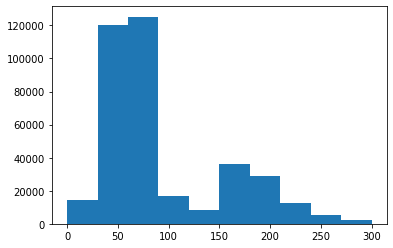

In [76]:
plt.hist(df_geo.exposures, range=[0, 300])
df_no_outlier = df_geo

0.0 180.0 -180.0 180.0


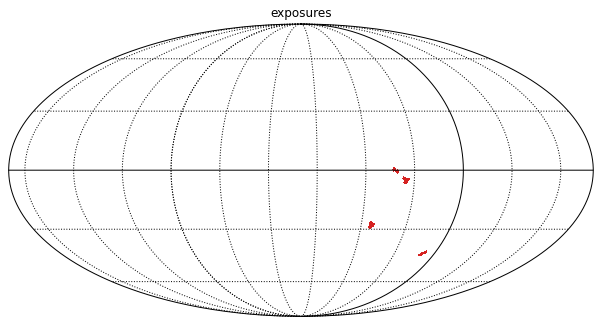

In [105]:
elem = 'exposures'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### b. pixel_id -> Plotting State of Current Catalogue



0.0 180.0 -180.0 180.0


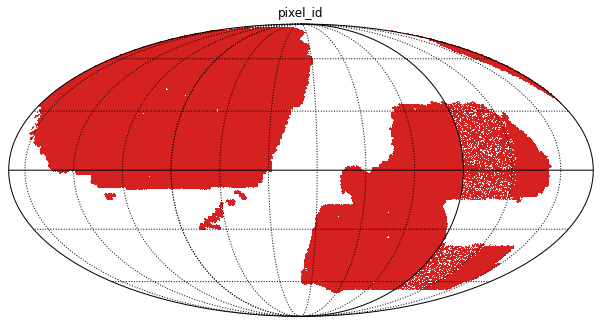

In [107]:
elem = 'pixel_id'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] < 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### c. lrg


0.0 180.0 -180.0 180.0


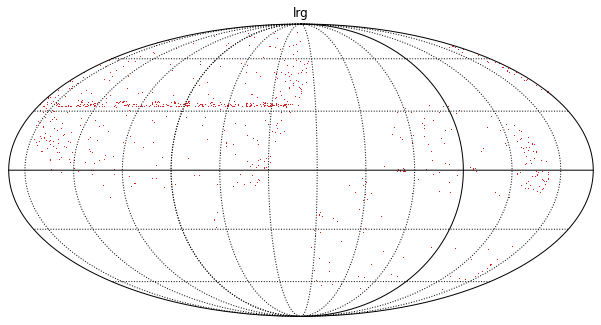

In [108]:
elem = 'lrg'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### d. elg


0.0 180.0 -180.0 180.0


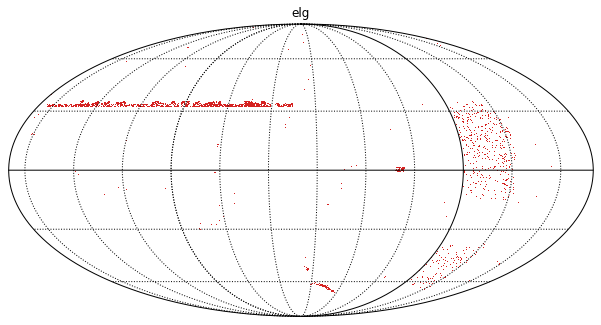

In [109]:
elem = 'elg'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### e. qso


0.0 180.0 -180.0 180.0


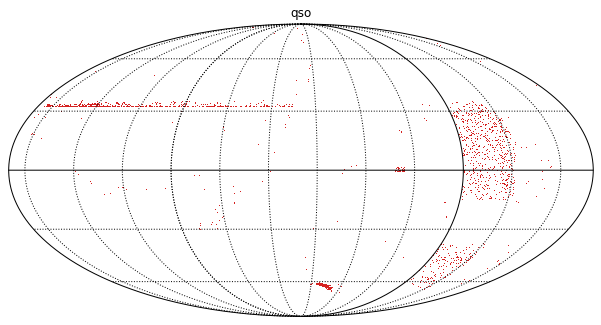

In [110]:
elem = 'qso'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### e. stellar


0.0 180.0 -180.0 180.0


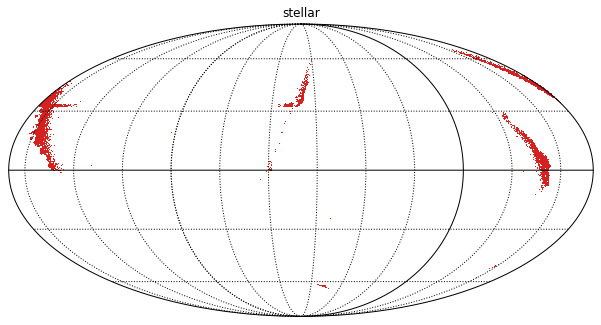

In [114]:
elem = 'stellar'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### f. EBV



0.0 180.0 -180.0 180.0


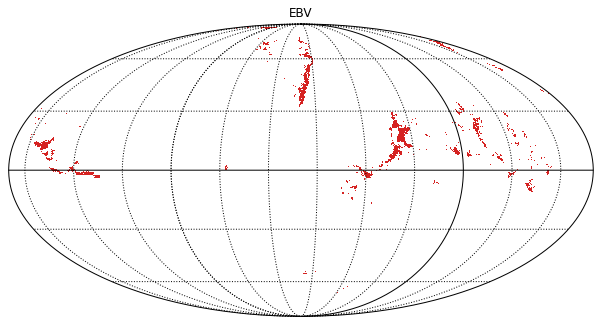

In [115]:
elem = 'EBV'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### g. exptime_g

0.0 180.0 -180.0 180.0


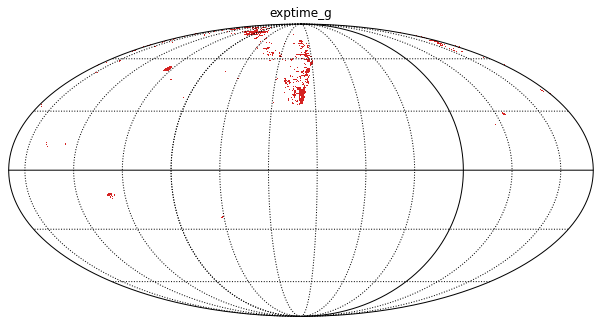

In [116]:
elem = 'exptime_g'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()


#### Plotting All combined

In [120]:
cols = list(df_geo.columns)
cols.remove('pixel_id')
cols.remove('Z')
print(len(cols))

25


/Users/edgareggert/miniconda3/envs/astro/lib/python3.8/site-packages/healpy/rotator.py:646: RuntimeWarning: invalid value encountered in double_scalars
  ang[0, :] = np.arccos(vz / r)
/Users/edgareggert/miniconda3/envs/astro/lib/python3.8/site-packages/healpy/rotator.py:646: RuntimeWarning: invalid value encountered in double_scalars
  ang[0, :] = np.arccos(vz / r)


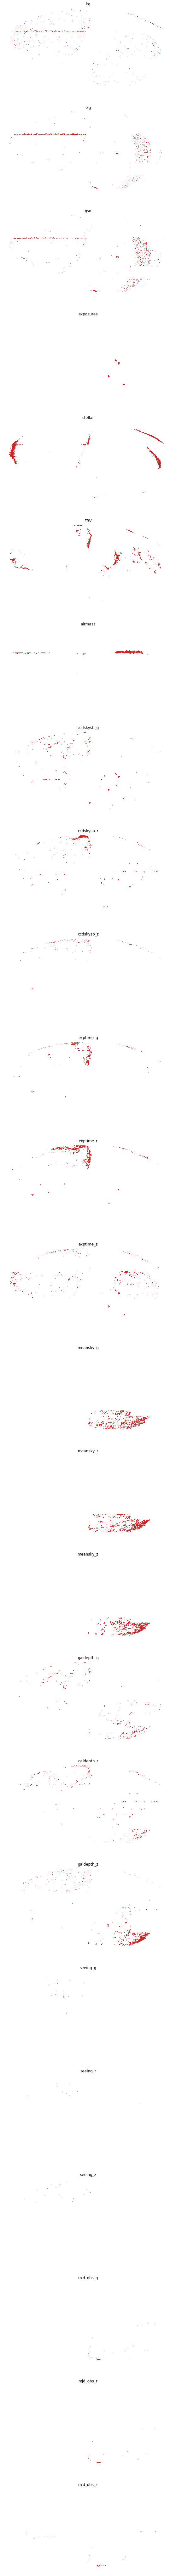

In [151]:
nrows = 25
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(150,150))

#fig = plt.figure()
i = 0
for ax in ax.flatten():
    elem = cols[i]
    df_no_outlier['Z'] = df_geo[elem].transform(zscore)

    df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

    m = np.zeros(NPIX)

    m[df_outlier.pixel_id.to_numpy()] = 1
    mask = (m == 0)
    m[mask] = np.nan

    plt.axes(ax)
    hp.mollview(m, title=elem, fig=fig, sub=(nrows, ncols, i + 1), min=-5, max=2, cbar=False, cmap="Reds", notext=False,
                rot=(100, 0, 0), badcolor='white',
                remove_dip=True, remove_mono=True, hold=True)
    #hp.graticule()
    i += 1

plt.show()
